# Decision Trees

Decision trees are a *tree based* method that can be used for regression or classification. Decision trees are a non-parametric model, meaning that few underlying assumptions about the data have to made. DTs are a simple, light-weight model, and are often used as a unit component of more complex models.

## Tree Structure

A [tree](https://en.wikipedia.org/wiki/Tree_(data_structure)) is a type of data structure consisting of a set of nodes. If a node has no parents (nodes above it in the tree structure), it is considered to be a *root node*. Similarly, if the node has no children (nodes below it), it is considered a *leaf node*. All nodes with exactly one parent and at least one child are called *decision nodes* (or, more generally, an *inner node*).

<img src="assets/decision_tree.png" align="center"/>

[Image source](https://www.smartdraw.com/decision-tree/)

Decision trees are a special type of *binary tree*, in which all decision nodes have exactly two children. These nodes represent decisions, or ways to split the data into two subsets. Each node asks a binary question about the data, and all points for which that question is true go into one child node, and the rest go into the other child node. This process repeats until the splitting criterion determines that all points in all nodes should no longer be split, completing the tree.

## Regression Trees

In regression problems you have seen in the past, you may have noticed that the data behaves differently in different parts of the domain. If using any sort of standard regression, this would be a source of bias in the model. Things fundamentally change depending on the value of $\overrightarrow{x}$, and thus a single line is not suitable for prediction. Consider the following simple example:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from scipy.stats import entropy

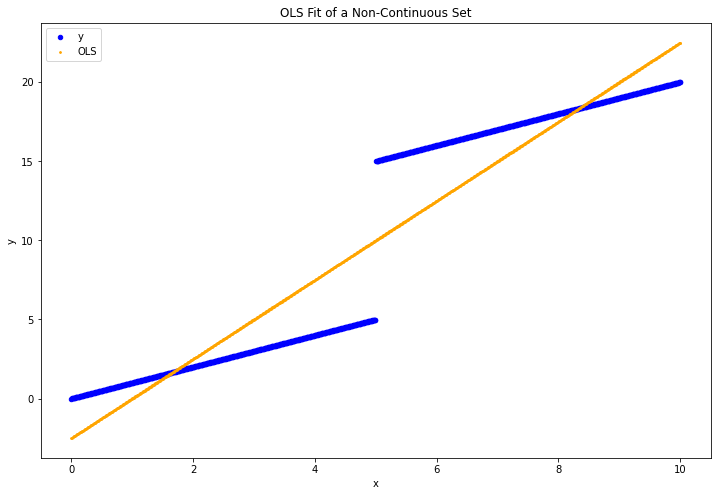

In [2]:
# create an array to represent a dataset
x = np.linspace(0, 10, 1000).reshape(-1, 1)

# create our label y
y = x.copy()
# and then shift half of it up by ten
y[500:] += 10

# fit with ols linear regression
lr = LinearRegression()
lr.fit(x, y)
ols = lr.predict(x)

# and plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y, color="blue", label="y", s=20)
ax.scatter(x, ols, color="orange", label="OLS", s=3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("OLS Fit of a Non-Continuous Set")
ax.legend();

In this example, our data clearly follows two distinct linear trends. However, the ordinary least squares algorithm doesn't know how to look for this. It fits on *all* of the data, and threfore is only accurate at two point. This is an easy fix, and all we have to do to get a perfect fit is to create two OLS fits instead of one:

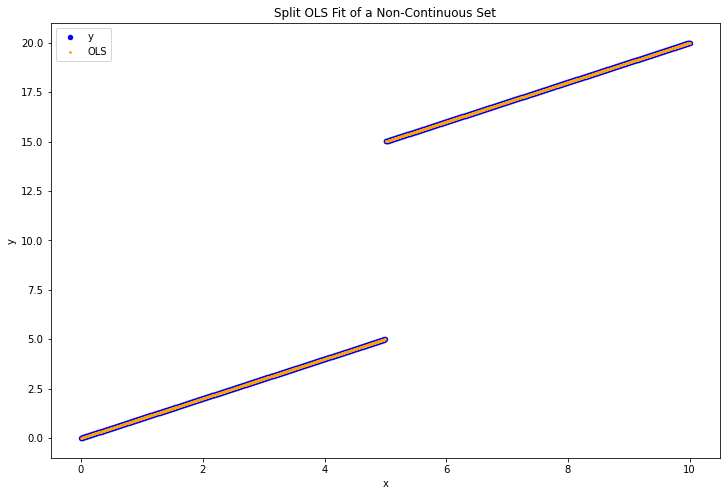

In [3]:
# split the data into two distinct sets for fitting
x1 = x[:500]
x2 = x[500:]

# the target as well
y1 = x1.copy()
y2 = x2 + 10

lr1 = LinearRegression()
lr1.fit(x1, y1)
ols1 = lr1.predict(x1)

lr2 = LinearRegression()
lr2.fit(x2, y2)
ols2 = lr2.predict(x2)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y, color="blue", label="y", s=20)
ax.scatter(x1, ols1, color="orange", label="OLS", s=3)
ax.scatter(x2, ols2, color="orange", s=3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Split OLS Fit of a Non-Continuous Set")
ax.legend();

However, this leaves quite a bit to be desired. What if the split isn't especially visable, or what if there is more than one? How would you handle two, three, ten, or one thousand splits? Manually coding indivdual OLS fits just isn't an option (not without a method to automate changes in the data, at least). 

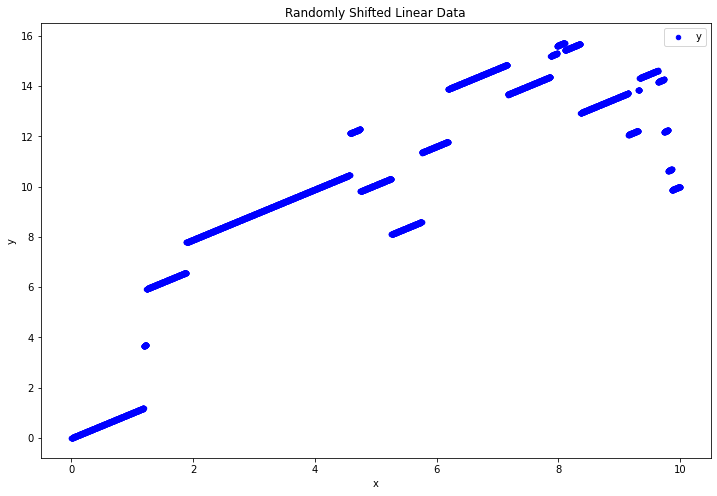

In [4]:
# create a variable that determines how many times
# a random subset of the data will be shifted up or down
NUM_SHIFTS = 10
DATA_SIZE = 10000

x = np.linspace(0, 10, DATA_SIZE).reshape(-1, 1)
y = x.copy()

for shift in range(NUM_SHIFTS):
    # choose a random index in the data as the lower bound
    bound1 = np.random.randint(low=0, high=DATA_SIZE)
    # choose a second random index as the upper bound
    bound2 = np.random.randint(low=bound1, high=DATA_SIZE)
    # generate a random number to shift the data by
    r = 3 * np.random.random()
    # add the random number to all y values between the bounds
    y[bound1: bound2] += r

# plot the now chaotic data
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y, color="blue", label="y", s=20)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Randomly Shifted Linear Data")
ax.legend();

Regression trees handle this exact problem. Implement a DecisionTreeRegressor object and fit it to our sample data.

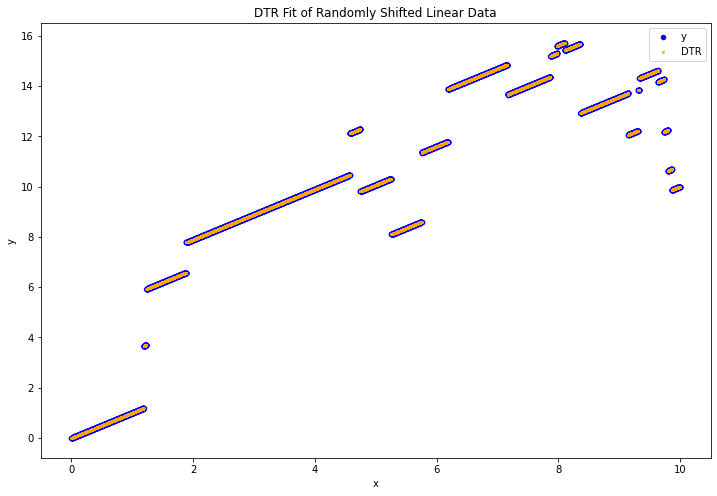

In [5]:
# implement and fit a dt object
dtr = DecisionTreeRegressor()
dtr.fit(x, y)

# predict y values
dtr_pred = dtr.predict(x)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y, color="blue", label="y", s=20)
ax.scatter(x, dtr_pred, color="orange", label="DTR", s=3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("DTR Fit of Randomly Shifted Linear Data")
ax.legend();

The DT fits the data *perfectly*. This is expected, as the data we created was perfectly linear on each subdomain. While there is some real world data that is segmented like this, the reality is that most of the time data is fairly continuous, and in those cases a DT will just be a set of very localized approximations.

### How to split the data?

Just as linear regression aims to minimize the error of its predictions, so does a regression tree. The default quanitity to minimize is the squared error, but other quantities such as the mean absolute error are available as well. Historically, minimization of statistical quantities such as variance or chi-squared was used as well, though these quantities are less interpretable.

### (Extra) Splitting Condition: Variance

Write a function that accepts a set of one-dimensional data and chooses a point to split on that minimizes the total variance of the two child sets, then returns those two sets. How would you modify your function to work with multi-dimensional data? How would you implement a function that minimizes MSE?

In [6]:
def splitter(x):
    variance = []
    for n in range(len(x)):
        c1, c2 = x[:n], x[n:]
        var = np.var(c1) + np.var(c2)
        variance.append(var)
    
    split = np.argmin(variance)
    
    return x[:argmin], x[argmin:]

### What about regularization?

A quick read of the [decision tree regressor documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) shows that the MSE used in splitting is just the $L^2$ loss with no Lasso or Ridge term. Similarly, there is no option to specify which type of regression is used in the fits. DTs are meant to be low-bias models, but letting them go unchecked would be unwise. How would you prevent a decision tree from over fitting?

Answer:

* Restrict depth
* Restrict number of leaf nodes
* Restrict number of samples per node
* Increase `ccp_alpha`

### The Regression Tree Algorithm

To build a decision tree, the algorithm must repeat the same steps at each node:

1. Loop through each feature

2. For each feature, compute the total MSE (or whatever splitting qunatity was specified) of the two splits for every single possible splitting point

3. Choose the feature-value pair which minimizes MSE

This process is repeated until any number of stopping criterion are met. Common stopping criterion are a max depth for the tree, a minimum number of samples per leaf, or the tree not being able to optimize any further.

### Check your understanding

* Are regression trees a low or high bias model? How about variance?

* When should one use regression trees?

* Are there any shortcomings of this model?

## Classification Trees

Similar to the regression case, decision trees can also be used to classify. In the very same fashion, the DT will ask a series of "yes or no" questions about the data to try and make it so each leaf node contains only a single category. For example, consider a set of questions that you might ask to determine if an animal is a dog.

You might first ask if it has four legs. This would eliminate primates and birds, as well as most bugs from child set containing dogs. Then, on the set of the data that did have four legs, you might ask if the creature has fur or not to eliminate reptiles and amphibians from the data. Then, on the set which has fur, you may ask if the weight of the animal is above 15 pounds, but this would produce two sets which both contain dogs: big dogs, and small dogs. For the small dogs, you could ask if the animal has retractable claws to remove cats from the set, while on the large dogs you may choose to split on weight again to remove large mammals from the set.

<img src="assets/animal_tree.png" align="center"/>

As the initial set of animals gets larger, one would have to ask more and more questions to accurately categorize each animal. For example, if a rabbit were put through the above set of questions, it would follow the same path as the small dog, and thus would be classified incorrectly.

### How to split the data?

If you were to try to quantify the decision making process, how would you do so? An intuitive measure is to try to make each child set as pure as possible. If a child set contains only one category, then it is perfectly pure and nothing more needs to be done with that data. We implement this logic using a quantity called the *Gini impurity*,

$$
G = \sum_{c} P(c|t)(1 - P(c|t)) = 1 - \sum_{c} P^{2}(c|t).
$$

Here, $P(c|t)$ represents the probability of observing category $c$ at node $t$. Then, each term in the first version of the sum can be interpreted as the probability that category $c$ is guessed ($P(c|t)$) *and* is incorrect ($1 - P(c|t)$). Therefore, when summed over, the Gini impurity represents the probability guessing the wrong category. Minimizing this quantity will maximize the number of correctly labeled outputs, and that is exactly what decision trees do. 

### (Extra) Splitting condition: Shannon Entropy

Another common splitting condition for classifier trees is to minimize the *entropy* of the two child sets. Entropy is fundamentally an information quantity, and the higher the entropy of a data set, the less about it we know. The Shannon entropy is defined as

$$
H(x) = \sum_{i} -P(x_i) \log(P(x_i)) = \sum_{i} P(x_i) \log\left(\frac{1}{P(x_i)}\right).
$$

This formula is far from intuitive, so here are a few different ways to interpret entropy:

* Entropy is a measure of the information in a system that we *cannot* know

* The binary ($\log_2$) entropy is a measure of the smallest number of bits that could theoretically represent a binary message

* Entropy measures how many different *microstates* give rise to the same *macrostate*

Chances are, none of those clear up the above formula, yet they are true. Why? Let's examine the logarithmic term, first. More specifically, we need intuition for the inverse probability. Imagine a situation where a coin is flipped, and you are asked to ask a single yes-or-no question to determine the result. For example, "was it heads?", and, regardless of the answer, you now know the outcome of the coin flip. By asking *one* binary question, you reveal which of *two* uncertain outcomes with probability $1/2$ occured. This corresponds to an inverse probability $1/\frac{1}{2}=2$. Let's take things a step further.

Imagine the same situation, but replace the coin with a die, and you are asked to guess the face on which it lands. If you guess wrong, the only thing you know is that it didn't land on your specified face. But if you guess right, you know that it *didn't land on any other face*. A positive event on the face you monitored tells the outcome of six possible events. $1/\frac{1}{6}=6$. Starting to see the pattern? The less likely an event is, the more it tells you about the system when that event actually does occur.

So why is it logarithmic? Logarithms added together is the same as numbers multiplying. Since probabilities combine by multiplying, we can reach the same result by adding their logarithms in a way that plays nice with differential calculus.

The last remaining piece is the probability that gets multiplied onto each logarithm. To understand this, consider the dice example again, but this time the dice will have painted faces. The "one" face will be painted green, and the other five faces will be painted red. Further more, the paint obscures the number so tht it cannot be determined. Now roll the dice. What number did you roll? If the green face was up, you know exactly: you rolled a one, and you didn't roll a two through six. This event has high information. But what if you rolled a red? In that case, the only thing you know is that you *didn't roll a one*. There are still five uncertain states in play. Thus, this event is low information. The high-information event is useful, but is unlikely, whereas the low-information events are almost useless, but will happen frequently. Both contribute to our knowledge about the system, and thus should be added together. Therefore, the total information in every possible outcome is the information of that outcome ($-\log P_i$) weighted by the probability of that outcome.

Therefore, by minimizing the entropy, we are maximizing the information we have about the data. This is analagous to minimizing purity, because a pure set has zero entropy.

### Back to the data

To prove the effectiveness of classification trees on real data, we'll use the familiar Titanic dataset. Since this is already familiar data, there's no need to spend much time cleaning and encoding the data. We'll simply drop the null values, as well as any columns which aren't immediately processable.

In [7]:
# load in the data, and drop any columns with null values
titanic_data = pd.read_csv('data/titanic.csv')
titanic_data = titanic_data.dropna(axis=1)
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
dtypes: float64(1), int64(5), object(3)
memory usage: 62.8+ KB


In [8]:
# one-hot encode the sex column
# then drop it, along with all other non-numeric columns (and Id)
sexes = pd.get_dummies(titanic_data["Sex"], drop_first=True)
titanic_data = titanic_data.drop(columns=["Name", "Ticket", "PassengerId", "Sex"])
titanic_data = pd.concat([titanic_data, sexes], join="inner", axis=1)
titanic_data.head(5)

,Survived,Pclass,SibSp,Parch,Fare,male
0,0,3,1,0,7.2500,1
1,1,1,1,0,71.2833,0
2,1,3,0,0,7.9250,0
3,1,1,1,0,53.1000,0
4,0,3,0,0,8.0500,1


In [9]:
# create our train and test splits
target = "Survived"
features = [col for col in titanic_data.columns if col != target]

X_train, X_test, y_train, y_test = train_test_split(titanic_data[features], titanic_data[target], random_state=42)

In [10]:
# fit an instance of DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train);

DecisionTreeClassifier()

Now, let's see how our model did

In [11]:
print(f"Training score: {dtc.score(X_train, y_train)}\nTest score: {dtc.score(X_test, y_test)}")

Training score: 0.9281437125748503
Test score: 0.8071748878923767


Looks like our model is fairly over fit. In general, without any limitations, a decision tree will keep splitting the data until the impurity can't be lowered any more, even if this means that each leaf only contains one entry. Let's see the total depth (read: longest chain of nodes) of our default classifier.

In [12]:
dtc.get_depth()

18

To help avoid over fitting, we can implement a value for `max_depth`, which will restrict how many nodes our model can contain.

In [13]:
dtc3 = DecisionTreeClassifier(max_depth=3)
dtc3.fit(X_train, y_train);

DecisionTreeClassifier(max_depth=3)

In [14]:
print(f"Training score: {dtc3.score(X_train, y_train)}\nTest score: {dtc3.score(X_test, y_test)}")

Training score: 0.811377245508982
Test score: 0.8071748878923767


This model has much higher bias than before, however, this time it has nearly equal performance on new data.

### Viewing the tree structure

sklearn makes it easy to view the structure of a decision tree. Using the `plot_tree` function, we can view the nodes and what is happening at them.

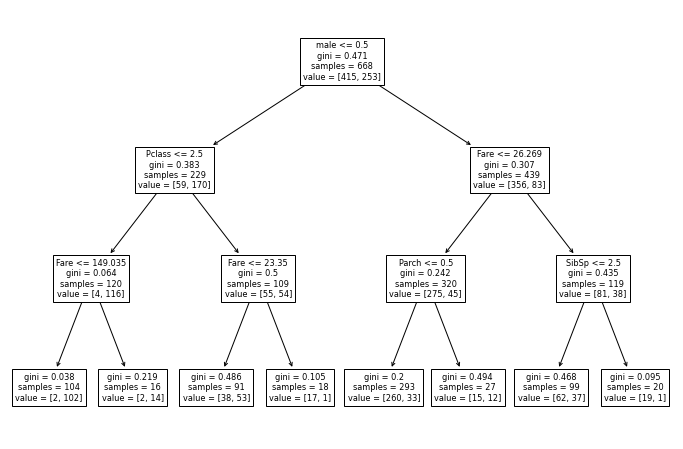

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))

plot_tree(dtc3, feature_names=features, ax=ax);

In addition, this allows us to infer information about our data in a hierarchal sense. The very first feature the model chose to split on was whether the passenger was male or female. This makes quite a bit of sense, given that the Titanic evacuation prioritized women and children. The next thing it prioritized was fare and class, both of which hold essentially the same information, which again makes sense. The rich passengers had much better survival rates compared to the poor.

### Feature importance

Decision trees also have a way to quantify the importance of each feature. The more the impurity is reduced by splitting the data on a feature, the more important it is. However, deep down in the tree, relatively pure data might be entering the lower nodes, so it doesn't make sense to give equal importance to the lower nodes. The importance is therefore calculated as the total impurity reduction at each node weighted by the probability of reaching that node. This gives the most weight to the root node, and the least weight to the deepest nodes in the tree. The DTC object has an importance attribute which will automatically calculate this for us.

In [16]:
importances = dtc3.feature_importances_

for feature, imp in zip(features, importances):
    print(f"The Gini importance of {feature} was {imp}")

The Gini importance of Pclass was 0.18038965091457113
The Gini importance of SibSp was 0.024798961350699845
The Gini importance of Parch was 0.03870854410089413
The Gini importance of Fare was 0.1009208751059169
The Gini importance of male was 0.655181968527918


### Check your understanding

* Which splitting metric would you use to explain the DT process to a client? Why?

* Would DTs generalize well to new data?

* What does the tree structure tell us about the decision making process?

## Decision Trees: Pros and Cons

### The good

* DTs are lightweight models
* Non-parametric
* Low bias
* Intepretable
* Great for inference

### The bad

* High variance
* Can't compete with complex models
* Need lots of data to properly fit
* Need relatively balanced classes

### The ugly

DTs are rarely used on there own. If a simple/interpretable model is needed, there are other options which can often perform better. However, they are exellent when used in groups as part of an ensemble model, such as random forests.